In [2]:
dataset = 7
keyframe = 4
image_id = 1

imagepath = f"/mnt/data/publicData/MICCAI19_SCARED/train/dataset{dataset}/keyframe{keyframe}/image_02/data/{image_id:010d}.png"


In [9]:
import numpy as np
import cv2
from preprocessing import AdaptiveHighlightDetector
import matplotlib.pyplot as plt
from typing import Optional, Tuple

def generate_highlight_mask(image: np.ndarray, 
                          scale_factor: float = 0.5,
                          base_threshold: float = 0.75,
                          min_area: int = 10) -> np.ndarray:
    """
    使用AdaptiveHighlightDetector生成图像的高光mask
    
    Args:
        image: 输入图像，可以是:
               - (H, W, 3) RGB格式，值范围[0, 255]的uint8数组
               - (H, W, 3) RGB格式，值范围[0, 1]的float32数组
        scale_factor: 缩放因子，用于加速处理（默认0.5）
        base_threshold: 基础检测阈值（默认0.75）
        min_area: 最小高光区域面积（默认10像素）
    
    Returns:
        highlight_mask: 高光区域mask，(H, W) float32数组，值范围[0, 1]
                       其中1.0表示高光区域，0.0表示正常区域
    
    Example:
        >>> image = cv2.imread('input.jpg')
        >>> image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        >>> mask = generate_highlight_mask(image_rgb, scale_factor=0.5)
        >>> # mask现在是一个0-1的数组，可以用于后续处理
    """
    
    # 创建自适应高光检测器
    detector = AdaptiveHighlightDetector(
        base_threshold=base_threshold,
        min_area=min_area
    )
    
    # 确保图像是RGB格式且值在正确范围
    if image.dtype == np.uint8:
        # 已经是0-255范围，直接使用
        image_input = image
    elif image.dtype == np.float32 and image.max() <= 1.0:
        # 转换为0-255范围
        image_input = (image * 255).astype(np.uint8)
    else:
        # 归一化到0-1然后转换到0-255
        image_normalized = np.clip(image.astype(np.float32), 0, 1)
        image_input = (image_normalized * 255).astype(np.uint8)
    
    # 生成高光mask
    highlight_mask, _ = detector.process(
        image_input,
        scale_factor=scale_factor
    )
    
    return highlight_mask


def read_image_old(image_path: str, 
               target_size = None,
               color_mode: str = 'RGB',
               normalize: bool = True) -> np.ndarray:
    """
    读取图像并返回ndarray格式
    
    Args:
        image_path: 图像文件路径
        target_size: 目标尺寸 (height, width)，为None时保持原尺寸
        color_mode: 颜色模式 'RGB' 或 'BGR'，默认为'RGB'
        normalize: 是否归一化到[0, 1]范围，默认为True
    
    Returns:
        image: ndarray格式的图像，形状为 (H, W, 3) 或 (H, W)
    
    Example:
        >>> image = read_image('test.jpg', target_size=(512, 640))
        >>> print(image.shape)  # (512, 640, 3)
        >>> print(image.dtype)  # float32
        >>> print(image.min(), image.max())  # 0.0 1.0
    """
    
    try:
        # 使用OpenCV读取图像
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        if image is None:
            raise ValueError(f"无法读取图像: {image_path}")
        
        # 转换颜色空间
        if color_mode.upper() == 'RGB':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif color_mode.upper() == 'BGR':
            pass  # 保持BGR格式
        else:
            raise ValueError("color_mode必须是'RGB'或'BGR'")
        
        # 调整尺寸
        if target_size is not None:
            height, width = target_size
            image = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)
        
        # 数据类型转换和归一化
        image = image.astype(np.float32)
        if normalize:
            image = image / 255.0
        
        return image
        
    except Exception as e:
        raise RuntimeError(f"读取图像时出错: {str(e)}")

# 简化版本的读取函数
def read_image(image_path: str) -> np.ndarray:
    """
    简化版本：读取图像并返回RGB格式的float32数组
    
    Args:
        image_path: 图像文件路径
    
    Returns:
        image: RGB格式的float32数组，值范围[0, 1]
    """
    return read_image_old(image_path, color_mode='RGB', normalize=True)

In [4]:
def plot_mask(image: np.ndarray, 
              mask: np.ndarray,
              title: str = "Highlight Detection Result",
              show: bool = True,
              alpha: float = 0.5,
              colormap: str = 'hot') -> None:
    """
    绘制原始图像和高光mask的对比图
    
    Args:
        image: 原始图像，RGB格式，值范围[0, 255]或[0, 1]
        mask: 高光mask，形状为(H, W)，值范围[0, 1]
        title: 图表标题
        save_path: 保存路径，为None时不保存
        show: 是否显示图像
        alpha: mask叠加透明度
        colormap: mask颜色映射
    """
    
    # 确保图像在正确范围
    if image.dtype == np.uint8:
        image_display = image.astype(np.float32) / 255.0
    else:
        image_display = np.clip(image, 0, 1)
    
    # 确保mask在正确范围
    mask_display = np.clip(mask, 0, 1)
    
    # 创建子图
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 原始图像
    axes[0].imshow(image_display)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # 高光mask
    axes[1].imshow(mask_display, cmap=colormap)
    axes[1].set_title('Highlight Mask')
    axes[1].axis('off')
    
    # 叠加显示
    axes[2].imshow(image_display)
    axes[2].imshow(mask_display, cmap=colormap, alpha=alpha)
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    
    # 设置总标题
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()

    if show:
        plt.show()
    else:
        plt.close()

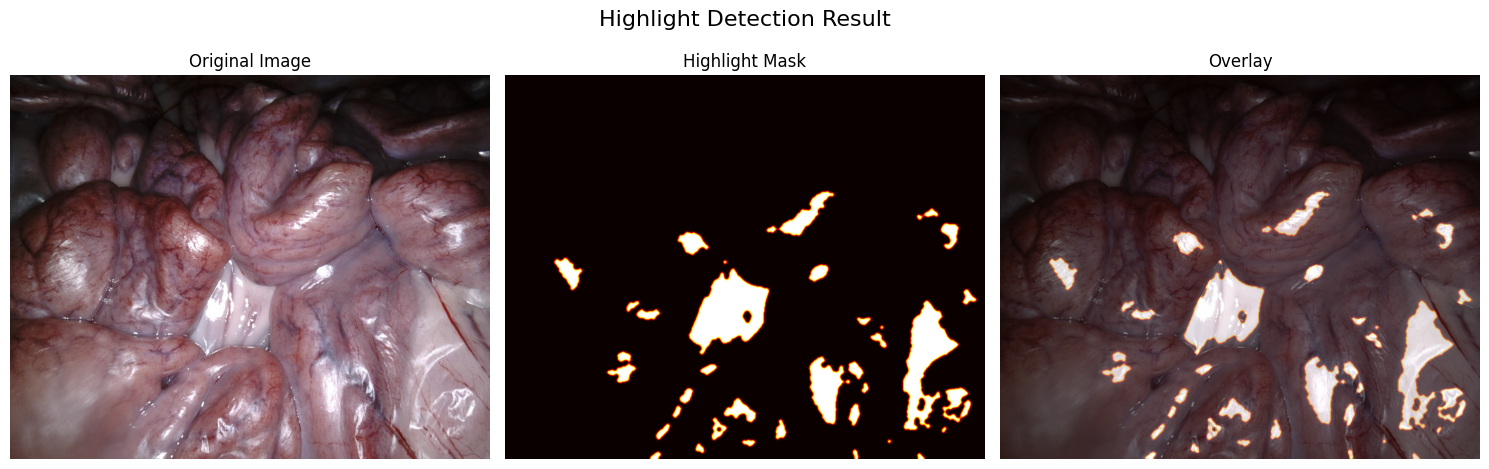

In [16]:
image = read_image(imagepath)
mask = generate_highlight_mask(image, base_threshold=0.95)
plot_mask(image, mask)